## LSTM for Floating Offshore Wind Turbine Motion Predictions
The following code creates and trains a long short-term memory (LSTM) machine learning model to predict the 6DoF motions of a floating offshore wind turbine (FOWT) using the following inputs:
- Surge
- Sway
- Heave
- Pitch
- Roll
- Yaw
- X-direction horizontal wind speed (Ux)
- Wave elevation at the platform (Hw)

In [103]:
import os
import datetime

import random
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas.plotting import scatter_matrix

Firstly the csv file containing 180000 seconds of time series data is read and stored as df:

In [104]:
df = pd.read_csv('OpenFASTData.csv')

The first 5 time steps are shown to ensure the csv file has been imported correctly:

In [105]:
df.head()

,Time,Ux,Hw,Surge,Sway,Heave,Roll,Pitch,Yaw
0,300.1,4.90,-0.844,1.61,1.29,-0.0974,-0.000546,0.0156,-0.00192
1,300.2,4.92,-0.907,1.59,1.26,-0.0975,-0.000300,0.0154,-0.00174
2,300.3,4.95,-0.973,1.58,1.23,-0.0973,-0.000047,0.0152,-0.00154
3,300.4,4.97,-1.040,1.56,1.21,-0.0967,0.000212,0.0150,-0.00134
4,300.5,5.00,-1.110,1.54,1.18,-0.0958,0.000476,0.0148,-0.00113


The data for each of the inputs is analysed to identify any possible anomalies that may affect training:

In [106]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,180000.0,1050.050000,433.013904,300.10000,675.07500,1050.05000,1425.025000,1800.0000
Ux,180000.0,15.570744,5.557966,2.78000,13.00000,15.40000,19.200000,40.1000
Hw,180000.0,-0.002334,0.975469,-6.67000,-0.50700,-0.00375,0.496000,5.7900
Surge,180000.0,14.970999,4.383498,0.20700,14.50000,16.00000,17.100000,27.4000
Sway,180000.0,-0.123203,0.737788,-1.80000,-0.56300,-0.05690,0.356000,1.8300
Heave,180000.0,-0.205229,0.178014,-1.04000,-0.31800,-0.20100,-0.079075,0.5150
Roll,180000.0,0.002327,0.001991,-0.00719,0.00126,0.00246,0.003560,0.0116
Pitch,180000.0,0.050107,0.017662,-0.00587,0.04020,0.04980,0.059800,0.1190
Yaw,180000.0,-0.007677,0.005960,-0.05140,-0.00994,-0.00688,-0.003880,0.0155


The wind speed time trace is plotted, this is done as it clearly shows the mild/average/extreme cases, confirming the cases are in the desired order:

*It should be noted that between cases there can be fluctuations which can be present in training, a further aspiration then would be to modify the model so that it could train on each of the cases seperately to avoid these fluctuations.*

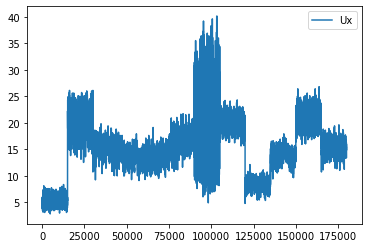

In [107]:
plot_cols = ['Ux']

plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

Check that all the data is of the same data-type, and ensure that the expected number of time steps are present:

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    180000 non-null  float64
 1   Ux      180000 non-null  float64
 2   Hw      180000 non-null  float64
 3   Surge   180000 non-null  float64
 4   Sway    180000 non-null  float64
 5   Heave   180000 non-null  float64
 6   Roll    180000 non-null  float64
 7   Pitch   180000 non-null  float64
 8   Yaw     180000 non-null  float64
dtypes: float64(9)
memory usage: 12.4 MB


Data is simulated so does not account for yearly/monthly/daily fluctuations, therefore the time data column is removed:

In [109]:
df.drop('Time', axis = 1, inplace = True)

A correlation matrix is used to see whether the inputs do actually have some impact on eachother:

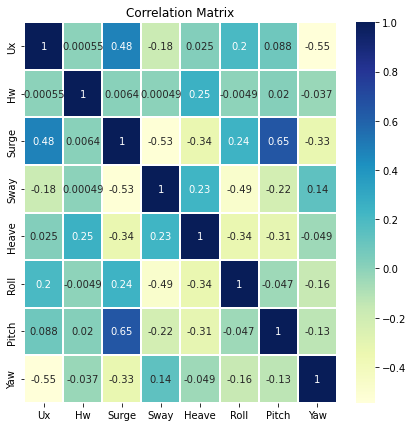

In [110]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), linewidth=.1, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show();

The data is now split in the train/test/validation sets:

In [111]:
col_ind = {name: i for i, name in enumerate(df.columns)} # Column names are associated with an index number for later use
length = len(df)

df_train = df[0:int((2/3)*length)]
df_test_mild = df[int((2/3)*length):int((3/4)*length)]
df_test_avg = df[int((3/4)*length):int((5/6)*length)]
df_test_ext = df[int((5/6)*length):int((11/12)*length)]
df_val = df[int((11/12)*length):]

num_features = df.shape[1] # The number of features are defined for later use

Each set is normalised:

In [112]:
mean = df_train.mean()
std = df_train.std()

df_test_mild = (df_test_mild - mean)/std
df_test_avg = (df_test_avg - mean)/std
df_test_ext = (df_test_ext - mean)/std
df_train = (df_train - mean)/std
df_val = (df_val - mean)/std

A violin plot is created to ensure there aren't any anomalies in the normalised data:

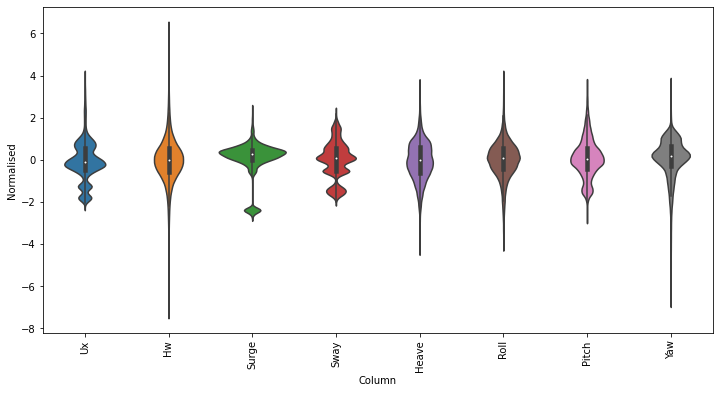

In [113]:
df_std = (df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

The *window_gen* class is created, which takes all the train/validation/test data and puts them into windowed datasets, with the use of a few functions, presented below: 

In [114]:
class window_gen():
    def __init__(self, input_width, label_width, shift,
                df_train=df_train, df_test_mild=df_test_mild, df_test_avg=df_test_avg,
                df_test_ext=df_test_ext, df_val=df_val, label_columns=None):
        
        # Raw data is stored:
        self.df_train = df_train
        self.df_test_mild = df_test_mild
        self.df_test_avg = df_test_avg
        self.df_test_ext = df_test_ext
        self.df_val = df_val
        
        L = len(df_val) # Stores length of validation set, i.e. length of one OpenFAST case
        
        self.label_columns = label_columns # Stores the label(s) to be predicted...
        if label_columns is not None:      # ...then assigns an index for each
            self.label_columns_indices = {name: i for i, name in
                                         enumerate(label_columns)}
        self.col_ind = {name: i for i, name in 
                              enumerate(df_train.columns)}
        
        # Store the input width, label width and shift:
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + label_width
        
        if (L % self.total_window_size) != 0: # An exception error is raised if the window size is not a factor of the each of
            raise Exception(f'Window size must be a factor of {L}!') # the case lengths (15000)
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

The following function will split the dataset into inputs and labels:

In [115]:
def window_split(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.col_ind[name]] for name in self.label_columns],
        axis=-1)
    
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

window_gen.window_split = window_split

The following 4 functions allow predictions to be plotted seperately for the training data and testing data:

In [116]:
def plot_train(self, model=None, plot_col='Sway', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.col_ind[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} (normalised)')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index],
                marker='.', label='Labels')
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index],
                     marker='.', label='Predictions')

        if n==0:
            plt.legend()
        
    plt.xlabel('Time (*0.1s)')
    
window_gen.plot_train = plot_train

In [117]:
def plot_avg(self, model=None, plot_col='Sway', max_subplots=3):
    inputs, labels = self.example_avg
    plt.figure(figsize=(12,8))
    plot_col_index = self.col_ind[plot_col]
    max_n = min(max_subplots, len(inputs))
    input_ind = self.input_indices*0.1
    label_ind = self.label_indices*0.1
    
    for n in range(1):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} (normalised)')
        plt.plot(input_ind, inputs[n, :, plot_col_index],
             label='Inputs', color='0.5', marker='.', zorder=-10) 
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(label_ind, labels[n, :, label_col_index],
                marker='.', label='Labels')
        if model is not None:
            predictions = model(inputs)
            plt.plot(label_ind, predictions[n, :, label_col_index],
                     marker='.', label='Predictions')

        if n==0:
            plt.legend()
        
    plt.xlabel('Time (s)')
    plt.title(f'Normalised {plot_col} Test Case Predictions:')
    
window_gen.plot_avg = plot_avg

In [118]:
def plot_mild(self, model=None, plot_col='Sway', max_subplots=3):
    inputs, labels = self.example_mild
    plt.figure(figsize=(12,8))
    plot_col_index = self.col_ind[plot_col]
    max_n = min(max_subplots, len(inputs))
    input_ind = self.input_indices*0.1
    label_ind = self.label_indices*0.1
    for n in range(1):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} (normalised)')
        plt.plot(input_ind, inputs[n, :, plot_col_index],
             label='Inputs', color='0.5', marker='.', zorder=-10) 
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(label_ind, labels[n, :, label_col_index],
                marker='.', label='Labels')
        if model is not None:
            predictions = model(inputs)
            plt.plot(label_ind, predictions[n, :, label_col_index],
                     marker='.', label='Predictions')

        if n==0:
            plt.legend()
        
    plt.xlabel('Time (s)')
    plt.title(f'Normalised {plot_col} Test Case Predictions - Mild Case:')

    
window_gen.plot_mild = plot_mild

In [119]:
def plot_ext(self, model=None, plot_col='Sway', max_subplots=3):
    inputs, labels = self.example_ext
    plt.figure(figsize=(12,8))
    plot_col_index = self.col_ind[plot_col]
    max_n = min(max_subplots, len(inputs))
    input_ind = self.input_indices*0.1
    label_ind = self.label_indices*0.1
    
    for n in range(1):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} (normalised)')
        plt.plot(input_ind, inputs[n, :, plot_col_index],
             label='Inputs', color='0.5', marker='.', zorder=-10) 
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(label_ind, labels[n, :, label_col_index],
                marker='.', label='Labels')
        if model is not None:
            predictions = model(inputs)
            plt.plot(label_ind, predictions[n, :, label_col_index],
                     marker='.', label='Predictions')

        if n==0:
            plt.legend()
        
    plt.xlabel('Time (s)')
    plt.title(f'Normalised {plot_col} Test Case Predictions - Extreme Case:')
    
window_gen.plot_ext = plot_ext

The dataset function creates the desired datasets, which are then split into inputs and labels using the *window_split* function:

In [120]:
def dataset(self, data):
    data = np.array(data, dtype=np.float32) # Convert the training/validation/testing data into a numpy array
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size, # The length of the dataset will be the combined length of inputs and labels
        sequence_stride=1, # The stride determines the period between successive datasets
        sampling_rate=1, # The sampling rate determines the period between the successive timesteps
        shuffle=True, # Shuffle is set to true so that the data is not in called chronologically
        batch_size=32,) # Determines how many training samples to go through before the model updates its internal parameters
        
    ds = ds.map(self.window_split) # Ensure the dataset can be mapped to the specified number of inputs and labels
    
    return ds

window_gen.dataset = dataset

Functions are defined so that the training, validation and testing data are split into the seperate datasets to be called upon later. The example functions are used to output the next batch of inputs and labels when plotting the predictions:

In [121]:
@property
def train(self):
    return self.dataset(self.df_train)

@property
def val(self):
    return self.dataset(self.df_val)

@property
def test_avg(self):
    return self.dataset(self.df_test_avg)

@property
def test_mild(self):
    return self.dataset(self.df_test_mild)

@property
def test_ext(self):
    return self.dataset(self.df_test_ext)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

@property
def example_avg(self):
    result = next(iter(self.test_avg))
  
    return result

@property
def example_mild(self):
    result = next(iter(self.test_mild))
  
    return result

@property
def example_ext(self):
    result = next(iter(self.test_ext))
  
    return result

window_gen.train = train
window_gen.val = val
window_gen.test_avg = test_avg
window_gen.test_mild = test_mild
window_gen.test_ext = test_ext
window_gen.example = example
window_gen.example_avg = example_avg
window_gen.example_mild = example_mild
window_gen.example_ext = example_ext

The window generator class is run to split the data into datasets containing inputs and labels, the length of which can be defined here. The indices of the datasets are output to ensure the desired lengths are acheived:

In [124]:
window = window_gen(input_width=300, label_width=300, shift=300, label_columns=['Sway'])
window

Total window size: 600
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

A class is created to define a baseline model to compare the final LSTM to, to make sure it shows significant improvement. This model simply repeats the inputs as the prediction. These 'predictions' are then plotted against the actual values:

451/451 [==============================] - 1s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.1157


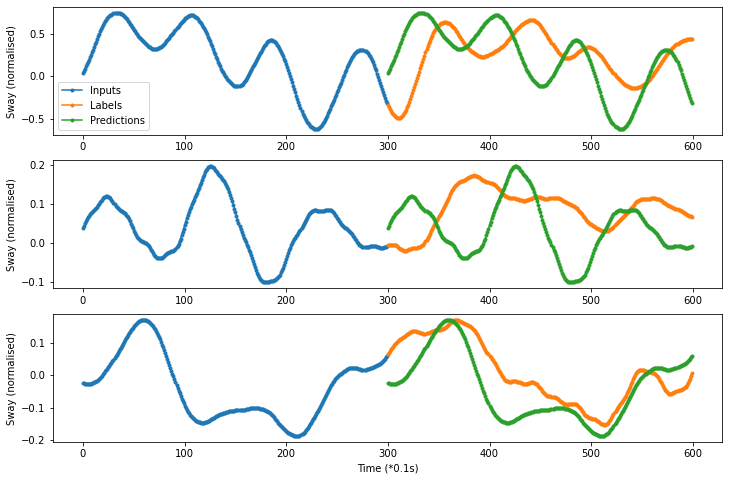

In [125]:
class baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

baseline = baseline(label_index=col_ind['Sway'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['baseline'] = baseline.evaluate(window.val)
performance['baseline'] = baseline.evaluate(window.test_avg, verbose=0,)

window.plot_train(baseline)

The cell below defines a function to train the LSTM using an Adam optimiser. Early stopping is used to stop training if the validation loss stops decreasing after 2 consecutive epochs, to prevent overfitting:

In [126]:
max_epochs = 100

def compile_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=0.00005),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=[early_stopping])
    
    return history

The LSTM is now set up and trained, with a set of predictions on the training data being plotted. The performance of the LSTM on the different validation set and testing sets are evaluated, with the validation MSE being output at every epoch:

451/451 [==============================] - 25s 56ms/step - loss: 0.0115 - mean_absolute_error: 0.0868


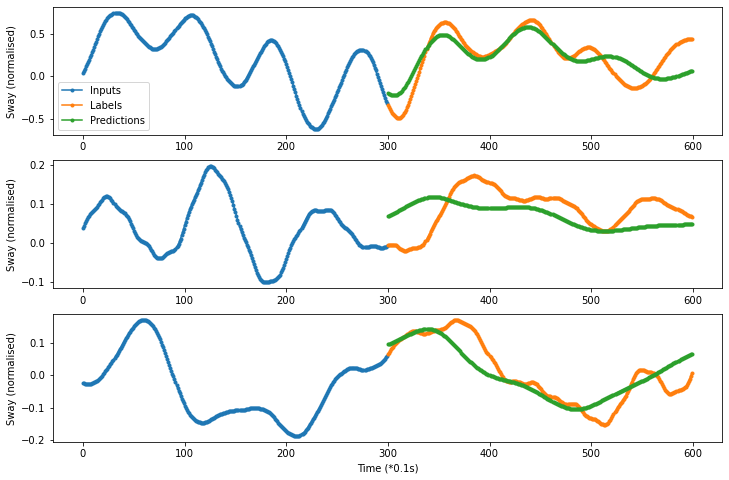

In [127]:
LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(300*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([300, num_features])
])

multi_val_performance = {}
multi_performance = {}
multi_performance_avg = {}
multi_performance_mild = {}
multi_performance_ext = {}

history = compile_fit(LSTM, window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = LSTM.evaluate(window.val)
multi_performance['LSTM'] = LSTM.evaluate(window.test_avg, verbose=0)
multi_performance_mild['LSTM'] = LSTM.evaluate(window.test_mild, verbose=0)
multi_performance_ext['LSTM'] = LSTM.evaluate(window.test_ext, verbose=0)

window.plot_train(LSTM)

The performance of the 3 testing sets is given:

In [128]:
print(multi_performance)
print(multi_performance_mild)
print(multi_performance_ext)

{'LSTM': [0.03049592673778534, 0.13959822058677673]}
{'LSTM': [0.05358079448342323, 0.1957114189863205]}
{'LSTM': [0.036460187286138535, 0.15320558845996857]}


The history of the training and validation performance per epoch is shown:

In [129]:
history.history

{'loss': [0.20073264837265015,
  0.07714641839265823,
  0.06939395517110825,
  0.06406696140766144],
 'mean_absolute_error': [0.291615754365921,
  0.18098269402980804,
  0.16950292885303497,
  0.16018207371234894],
 'val_loss': [0.013039352372288704,
  0.011376043781638145,
  0.011579213663935661,
  0.011472252197563648],
 'val_mean_absolute_error': [0.09200125187635422,
  0.08482525497674942,
  0.08665593713521957,
  0.08679318428039551]}

An example prediction on the average test set is plotted:

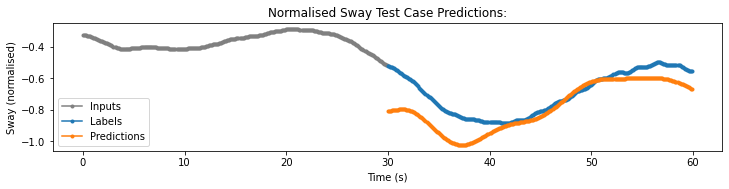

In [136]:
window.plot_avg(LSTM)

An example prediction on the mild test set is plotted:

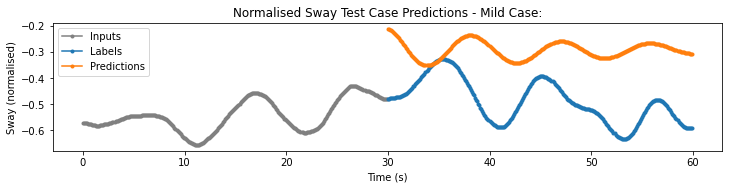

In [137]:
window.plot_mild(LSTM)

An example prediction on the extreme test set is plotted:

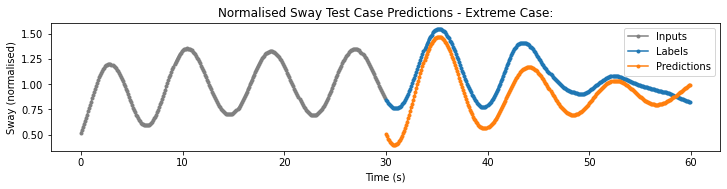

In [138]:
window.plot_ext(LSTM)

The training and validation losses per epoch are compiled into arrays:

In [ ]:
trlosses = [0.34398987889289856,
  0.07347120344638824,
  0.06466538459062576,
  0.05804337188601494,
  0.053012728691101074,
  0.04910288006067276,
  0.04675468057394028,
  0.04420750215649605]

In [ ]:
vallosses = [0.05052793398499489,
  0.03892650455236435,
  0.033928003162145615,
  0.03071475960314274,
  0.02862093225121498,
  0.026886247098445892,
  0.029687073081731796,
  0.029423052445054054]

The square roots of the losses are calculated to get the NRMSE at each epoch:

In [ ]:
epochs = np.linspace(1,len(vallosses),len(vallosses))
vallosses = np.array(vallosses)
trlosses = np.array(trlosses)
vallosses = np.sqrt(vallosses)
trlosses = np.sqrt(trlosses)

The training and validation losses are plotted against the number of epochs:

In [ ]:
plt.plot(epochs,vallosses, marker = 'o', label = 'Validation Loss')
plt.plot(epochs,trlosses, marker = 'o', label = 'Training Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend()
plt.show()